In [1]:
from gensim.models import Word2Vec
import gensim
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import svd
import numpy as np
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap
from sklearn.cluster import KMeans

/home/erik/miniconda3/envs/expenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SentenceIterator:
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        with open(self.filename, 'r') as f:
            for line in f:
                yield line.strip("\n").split(" ")

In [3]:
iterator_1 = SentenceIterator("../semeval2020_ulscd_swe/corpus1/lemma/kubhist2a.txt")
iterator_2 = SentenceIterator("../semeval2020_ulscd_swe/corpus2/lemma/kubhist2b.txt")

In [4]:
#model_1 = gensim.models.Word2Vec(iterator_1, window=5)
#model_2 = gensim.models.Word2Vec(iterator_2, window=5)
# Option to use skip-grams
model_1 = gensim.models.Word2Vec(iterator_1, window=5, sg=1)
model_2 = gensim.models.Word2Vec(iterator_2, window=5, sg=1)

In [5]:
# Save the models somewhere
model_1.save("../models/model_old_sg.model")
model_2.save("../models/model_new_sg.model")

In [3]:
#Load the models here if you already have computed embeddings and saved the models
model_1 = Word2Vec.load("../models/model_old_sg.model")
model_2 = Word2Vec.load("../models/model_new_sg.model")

In [4]:
# Find the words that both models have in their vocabulary
common_words = list(set(model_1.wv.key_to_index.keys()).intersection(set(model_2.wv.key_to_index.keys())))

In [5]:
# Align matrices using SVD
def align_matrices(A, B):
    u, sigma, vT = svd(np.matmul(A, B.transpose()), full_matrices=False)
    R = np.matmul(vT.transpose(), u.transpose())
    A_new = np.matmul(R, A)
    return A_new, B, R

def align_embeddings(emb_1, emb_2):
    emb1_new, _, R = align_matrices(emb_1.transpose(),emb_2.transpose())
    return emb1_new.transpose(), emb_2, R

In [6]:
common_embs_1 = np.array([model_1.wv[word] for word in common_words])
common_embs_2 = np.array([model_2.wv[word] for word in common_words])

In [7]:
all_embs_1 = np.array([model_1.wv[word] for word in model_1.wv.key_to_index.keys()])
all_embs_2 = np.array([model_2.wv[word] for word in model_2.wv.key_to_index.keys()])

In [8]:
# Rotate the embeddings for model 1 to align more with the embeddings of model 2
common_embs_1, _, R = align_embeddings(common_embs_1, common_embs_2)

In [9]:
all_embs_1 = np.matmul(R, all_embs_1.transpose()).transpose()

In [10]:
emb_dict_1 = {}
emb_dict_2 = {}

for i, word in enumerate(model_1.wv.key_to_index.keys()):
    emb_dict_1[word] = all_embs_1[i]
for i, word in enumerate(model_2.wv.key_to_index.keys()):
    emb_dict_2[word] = all_embs_2[i]

In [11]:
# Calculate the similarities between model 1 and 2 for all words in the vocabulary
similarities = {}
for word in common_words:
    similarities[word] = cosine_similarity(emb_dict_1[word].reshape(1,-1),emb_dict_2[word].reshape(1,-1))[0][0]

In [12]:
sorted_by_similarity = sorted(similarities.items(), key = lambda x : x[1])

In [13]:
# Examine the words which have the largest distance between the corpora
sorted_by_similarity[:10]

[('vant', 0.025297908),
 ('inlägg', 0.054509662),
 ('träning', 0.055805728),
 ('klas', 0.06549085),
 ('svinna', 0.07552011),
 ('simla', 0.07753431),
 ('storstad', 0.09728634),
 ('vetta', 0.09746514),
 ('mohn', 0.09827229),
 ('km', 0.09880744)]

In [14]:
# A function to compare the n most similar words to a given word, for two models
def compare_most_similar(model_1, model_2, word, n=10):
    most_similar_1 = model_1.wv.most_similar(word, topn=n)
    most_similar_2 = model_2.wv.most_similar(word, topn=n)
    print("\t Model 1 \t\tModel 2")
    for i in range(min(len(most_similar_1),len(most_similar_2))):
        print(f"{i}\t{most_similar_1[i][0]}: {most_similar_1[i][1]:.3f}\t\t{most_similar_2[i][0]}: {most_similar_2[i][1]:.3f}")

In [15]:
target_word = "politik"
compare_most_similar(model_1, model_2, target_word)

	 Model 1 		Model 2
0	grundsattser: 0.824		utrikespolitik: 0.823
1	grundsats: 0.823		unionspolitik: 0.807
2	system: 0.815		inrikespolitik: 0.805
3	statsförbund: 0.808		vensterpolitiken: 0.781
4	statsrätt: 0.802		phas: 0.778
5	espri: 0.801		präss: 0.775
6	princip: 0.800		unionsfiendtliga: 0.774
7	statskonst: 0.800		unionssaken: 0.774
8	diplomatik: 0.800		fredspolitik: 0.772
9	svstem: 0.799		regeringschef: 0.772


In [18]:
# Reduce the dimensions of embeddings using umap
def reduce_dimensions(embeddings, n_neighbors=10, min_dist=0.1, dimensions=2, metric='cosine'):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=dimensions, metric=metric, random_state=42)
    reduc_dim_embs = reducer.fit_transform(embeddings)
    return reduc_dim_embs

In [19]:
# Cluster using kmeans
def cluster(embeddings, n):
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    return labels

In [20]:
# Visualize dimension reduced word embeddings for two different models.
# reduced_embeddings is expected to be in an array with first the embeddings for model 1, then the embeddings for model 2,
# with equally many of both.
# To view clusters, set cluster=True and pass cluster_labels to the function.
def visualize(reduced_embs_1, reduced_embs_2, model_1, model_2, target_word, common_vocab=False, topn=10, cluster=False, cluster_labels=None):
    reduced_dict_1 = {}
    reduced_dict_2 = {}
    
    model_1_words = model_1.wv.key_to_index.keys()
    model_2_words = model_2.wv.key_to_index.keys()
    
    if common_vocab == False:
        for i, w in enumerate(model_1_words):
            reduced_dict_1[w] = reduced_embs_1[i]
        for i, w in enumerate(model_2_words):
            reduced_dict_2[w] = reduced_embs_2[i]
    elif type(common_vocab) == list:
        for i, w in enumerate(common_vocab):
            reduced_dict_1[w] = reduced_embs_1[i]
            reduced_dict_2[w] = reduced_embs_2[i]
    else:
        return 0


    most_similar_1 = model_1.wv.most_similar(target_word, topn=topn)
    most_similar_1.append((target_word, 1.0))

    most_similar_2 = model_2.wv.most_similar(target_word, topn=topn)
    most_similar_2.append((target_word, 1.0))

    mix_similar = [most_similar_1, most_similar_2]
    

    #2D
    if reduced_embs_1.shape[1] == 2:
        plt.ion()
        plt.figure(figsize=(10, 8))
        cmap = get_cmap("tab10") # Choose "tab10", "viridis", "plasma"
        
        for j, words in enumerate(mix_similar):
            for i, tuple in enumerate(words):
                try:
                    reduced_dict = [reduced_dict_1, reduced_dict_2][j]
                    x, y = reduced_dict[tuple[0]]
                except KeyError:
                    continue

                if cluster:
                    cluster_label = cluster_labels[i]
                    plt.scatter(x, y, color=cmap(cluster_label), label=f"Cluster {cluster_label}" if f"Cluster {cluster_label}" not in plt.gca().get_legend_handles_labels()[1] else None)
                else:
                    plt.scatter(x, y, color=['blue','red'][j])

                plt.text(x + 0.01, y + 0.01, tuple[0], fontsize=9)

        plt.xlabel("UMAP Dimension 1")
        plt.ylabel("UMAP Dimension 2")
        if cluster:
            plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
        
        plt.plot()

    elif reduced_embs_2.shape[1] == 3:
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        cmap = get_cmap("tab10") # Choose "tab10", "viridis", "plasma"

        for j, words in enumerate(mix_similar):
            for i, tuple in enumerate(words):
                try:
                    reduced_dict = [reduced_dict_1, reduced_dict_2][j]
                    x, y, z = reduced_dict[tuple[0]]
                except KeyError:
                    continue

                if cluster:
                    cluster_label = cluster_labels[i]
                    ax.scatter(x, y, z, color=cmap(cluster_label), label=f"Cluster {cluster_label}" if f"Cluster {cluster_label}" not in plt.gca().get_legend_handles_labels()[1] else None)
                else:
                    ax.scatter(x, y, z, color=['blue','red'][j])

                ax.text(x + 0.01, y + 0.01, z + 0.01, tuple[0], fontsize=8)

        ax.set_xlabel("UMAP Dimension 1")
        ax.set_ylabel("UMAP Dimension 2")
        ax.set_zlabel("UMAP Dimension 3")
        if cluster:
            ax.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.plot()

In [66]:
# Reduce the embeddings to be able to compare them visually
all_embs = np.concatenate((all_embs_1, all_embs_2))
all_reduced_embs = reduce_dimensions(all_embs, dimensions=2)

/home/erik/miniconda3/envs/expenv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [67]:
reduced_embs_1 = all_reduced_embs[:len(all_embs_1)]
reduced_embs_2 = all_reduced_embs[len(all_embs_1):]

In [71]:
# Save the vectors to the disk.
np.save("../embeddings/reduced_embs_min_20_n_neighbors_100.npy", all_reduced_embs)
np.save("../embeddings/reduced_embs_1_min_20_n_neighbors_100.npy", reduced_embs_1)
np.save("../embeddings/reduced_embs_2_min_20_n_neighbors_100.npy", reduced_embs_2)

In [23]:
# Or load already saved embeddings
reduced_embs = np.load("../embeddings/reduced_embs.npy")
reduced_embs_1 = np.load("../embeddings/reduced_embs_1.npy")
reduced_embs_2 = np.load("../embeddings/reduced_embs_2.npy")

/tmp/ipykernel_198187/3122262601.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10") # Choose "tab10", "viridis", "plasma"


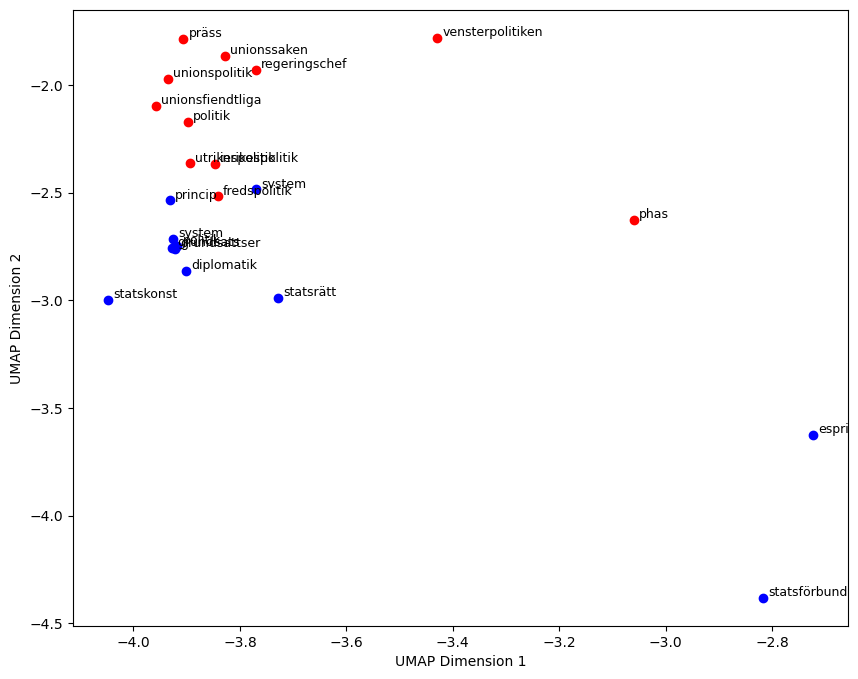

In [28]:
# Visualize the semantic change!

# Option to use clusters
#labels = cluster(reduced_embs, 5)
#visualize(reduced_embs_1, reduced_embs_2, model_1, model_2, "hund", cluster=True, cluster_labels=labels)

visualize(reduced_embs_1, reduced_embs_2, model_1, model_2, "politik")